In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 40)
import numpy as np
import hyperopt
from hyperopt import hp, tpe, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score,auc,roc_curve
import xgboost as xgb
from sklearn.model_selection import KFold,StratifiedKFold
from collections import Counter
import pickle
#import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)

In [2]:
train=pd.read_csv('prepped_train.csv')

In [3]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

class_weights = get_class_weights(train.stroke.values)
print(class_weights)

{0.0: 1.0, 1.0: 54.43}


In [4]:
X=train.drop(['stroke','id'],axis=1)
Y=train['stroke']

In [5]:
# # Hyperparameter tuning
# param_dict={}
# space = {
#         'max_depth': hp.choice('max_depth', np.arange(1, 10, dtype=int)),
#         'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
#         'subsample': hp.uniform('subsample', 0.5, 1),
#         'n_estimators': hp.choice('n_estimators', np.arange(100, 600, 10, dtype=int)),
#         'eta': hp.uniform('eta', 0.01, 0.1),
#         'gamma': hp.uniform('gamma', 0, 10),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
#     }


# def objective(space):
#     params = {
#             'min_child_weight': space['min_child_weight'],
#             'eta': space['eta'],
#             'colsample_bytree': space['colsample_bytree'],
#             'max_depth': space['max_depth'],
#             'subsample': space['subsample'],
#             'gamma': space['gamma'],
#             'n_estimators': space['n_estimators'],
#             'silent': 1,
#             'verbose_eval': True,
#     'objective':'binary:logistic',}
#     xgtrain = xgb.DMatrix(X, label=Y)
#     cv = xgb.cv(params,
#                 xgtrain,
#                 nfold=5,metrics='auc',
#                 num_boost_round=10000,
#                 early_stopping_rounds=50, as_pandas=True,stratified=True)
#     au = cv['test-auc-mean'].values[-1]
#     params['n_estimators']=cv.index[-1]
#     param_dict[au]=params
#     pickle.dump(param_dict,open('params','wb'))
#     print(params, file=open("output_xg.txt", "a"))
#     print(params)
#     print('max='+str(max(param_dict.keys())))
#     print ('auc = ', au)
#     print(au, file=open("output.txt", "a"))
#     return{'loss': -au, 'status': STATUS_OK}
# try:
    
#     trials = Trials()
#     best = hyperopt.fmin(fn=objective,
#         space=space,
#         algo=tpe.suggest,
#         max_evals=1000,
#         trials=trials
#         )
# except:
#     pass

In [6]:
xg_params={'min_child_weight': 6, 'eta': 0.06260989914605466, 'colsample_bytree': 0.5560612895633646, 'max_depth': 3, 'subsample': 0.6108971879329279, 'gamma': 0.2235564903371027, 'n_estimators': 131, 'silent': 1, 'verbose_eval': True, 'objective': 'binary:logistic'}
# max=0.8651114
# auc =  0.8651114

In [7]:
test=pd.read_csv('prepped_test.csv')

In [8]:
ids=test['id']
del test['id']
del test['stroke']

In [9]:
# Train on full data
xgtrain = xgb.DMatrix(X, label=Y)
model = xgb.train(xg_params,xgtrain,xg_params['n_estimators'])

In [10]:
xgtest=xgb.DMatrix(test,feature_names=test.columns)
predictions=model.predict(xgtest)

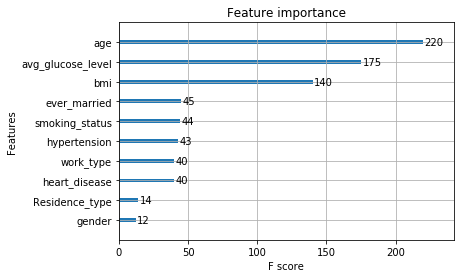

In [11]:
xgb.plot_importance(model)

In [12]:
op=pd.DataFrame()
op['id']=ids
op['stroke']=predictions
op.to_csv('op.csv',index=False)